# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN, InputLayer
from tensorflow.keras.utils import plot_model

## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

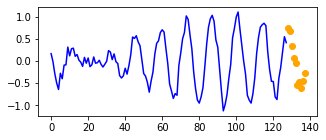

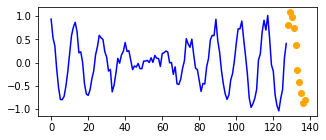

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [3]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

In [4]:
def slice(x, slice_length):
  return x[:, -slice_length:, :]

def create_model():
  _model = Sequential([
                      Convolution1D(filters=32, kernel_size=5, padding="causal", input_shape=(None, 1)),
                      Convolution1D(filters=32, kernel_size=5, padding="causal"),
                      Convolution1D(filters=32, kernel_size=5, padding="causal"),
                      Convolution1D(filters=32, kernel_size=5, padding="causal"),
                      Dense(1),
                      Lambda(slice, arguments = {'slice_length': look_ahead})
  ])

  _model.compile(optimizer="sgd", loss="mse")

  return _model

model1 = create_model()

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________________________________________

In [5]:
from sklearn.model_selection import train_test_split

X, y = gen_data()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
X_train.shape, X_valid.shape

((800, 128, 1), (200, 128, 1))

In [7]:
BATCH_SIZE = 25
EPOCHS = 15

In [8]:
history1 = model1.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 3s 13ms/step - loss: 0.1696 - val_loss: 0.0431
Epoch 2/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0394 - val_loss: 0.0424
Epoch 3/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0415
Epoch 4/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0413
Epoch 5/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0366 - val_loss: 0.0406
Epoch 6/15
32/32 [==============================] - 0s 6ms/step - loss: 0.0363 - val_loss: 0.0401
Epoch 7/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0396
Epoch 8/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0394
Epoch 9/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0384
Epoch 10/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0349 - val_loss: 0.0381
Epoch 11/15
32/32 

### Make repeated predictions



Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [9]:
x_test,y_test = gen_data(size=1, noise=0.0)
print(x_test.shape)
print(y_test.shape)

model1.predict(x_test).reshape(-1)  #Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([ 1.0028574 ,  0.98916614,  0.78879136,  0.44440776,  0.02851457,
       -0.37196437, -0.6740185 , -0.8159215 , -0.7699685 , -0.5479219 ],
      dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.  

In [10]:
def predict_sequence(_model, _x, _n):
  data = _x.copy()

  for _ in range(_n):
    prediction = _model.predict(data)
    data = np.hstack([data, prediction])

  return data

In [11]:
predicted_squence = predict_sequence(model1, x_test, 12)

In [12]:
def plot_predicted_sequence(_x, _predicted_squence, title=""):
  start_new_sequence = len(_x.reshape(-1))
  end_new_sequence = len(_predicted_squence.reshape(-1))

  fig, ax = plt.subplots(figsize=(10,4)) 
  ax.plot(range(0, start_new_sequence), _x.reshape(-1), 'b-')
  ax.plot(range(start_new_sequence-1, end_new_sequence), _predicted_squence.reshape(-1)[start_new_sequence-1:], 'r-')

  ax.set_title(title)

  plt.show()

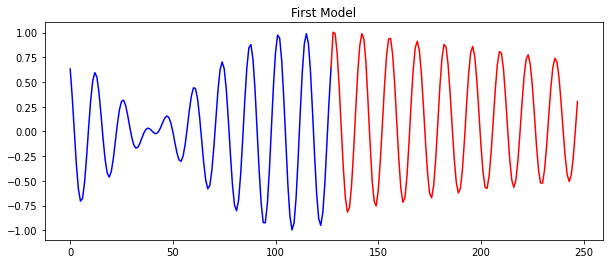

In [13]:
plot_predicted_sequence(x_test, predicted_squence, "First Model")

## B) 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)

Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [14]:
def create_model_with_dilation(dilation_rate):

  _model = Sequential()
  _model.add(Convolution1D(filters=32, kernel_size=5, padding="causal", dilation_rate=1, input_shape=(None, 1)))

  for i in range(2, dilation_rate+1):
      _model.add(Convolution1D(filters=32, kernel_size=5, padding="causal", dilation_rate=i))

  _model.add(Dense(1))
  _model.add(Lambda(slice, arguments = {'slice_length': look_ahead}))

  _model.compile(optimizer="sgd", loss="mse")

  return _model

In [15]:
model2 = create_model_with_dilation(dilation_rate=2)
model4 = create_model_with_dilation(dilation_rate=4)
model8 = create_model_with_dilation(dilation_rate=8)

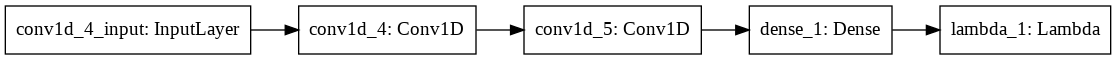

In [16]:
plot_model(model2, rankdir="LR")

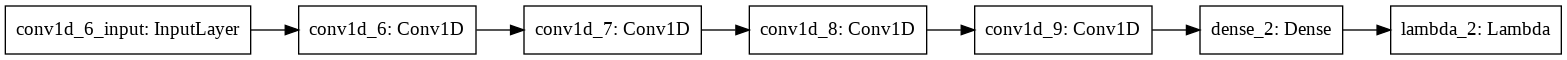

In [17]:
plot_model(model4, rankdir="LR")

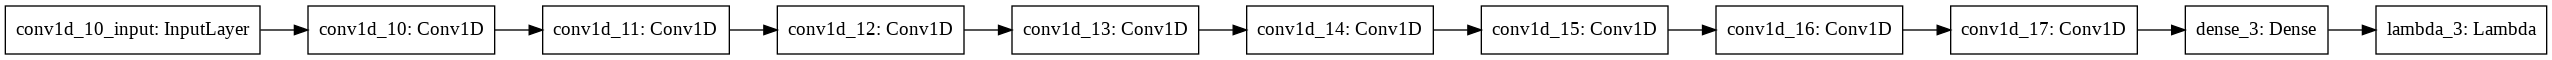

In [18]:
plot_model(model8, rankdir="LR")

In [19]:
history2 = model2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 1s 7ms/step - loss: 0.0627 - val_loss: 0.0378
Epoch 2/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0375
Epoch 3/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0369
Epoch 4/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0328 - val_loss: 0.0364
Epoch 5/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0358
Epoch 6/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0356
Epoch 7/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0329 - val_loss: 0.0349
Epoch 8/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0346
Epoch 9/15
32/32 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0342
Epoch 10/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.0338
Epoch 11/15
32/32 [

In [20]:
history4 = model4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 1s 8ms/step - loss: 0.1548 - val_loss: 0.0663
Epoch 2/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0620 - val_loss: 0.0532
Epoch 3/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0482 - val_loss: 0.0413
Epoch 4/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0392 - val_loss: 0.0329
Epoch 5/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0265
Epoch 6/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0242 - val_loss: 0.0223
Epoch 7/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 8/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0179
Epoch 9/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 10/15
32/32 [==============================] - 0s 3ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 11/15
32/32 [

In [21]:
history8 = model8.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 1s 12ms/step - loss: 0.1806 - val_loss: 0.0149
Epoch 2/15
32/32 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 3/15
32/32 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 4/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 5/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 6/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 7/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 8/15
32/32 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 9/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 10/15
32/32 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 11/15
32/32 

In [67]:
model8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 32)         

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [22]:
predicted_squence2 = predict_sequence(model2, x_test, 12)
predicted_squence4 = predict_sequence(model4, x_test, 12)
predicted_squence8 = predict_sequence(model8, x_test, 12)

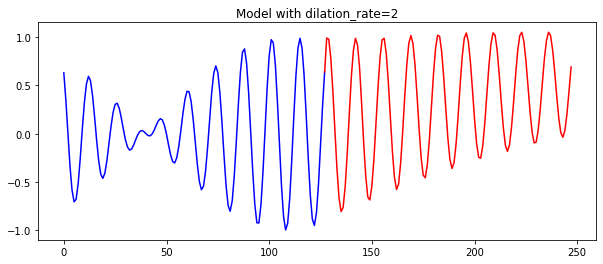

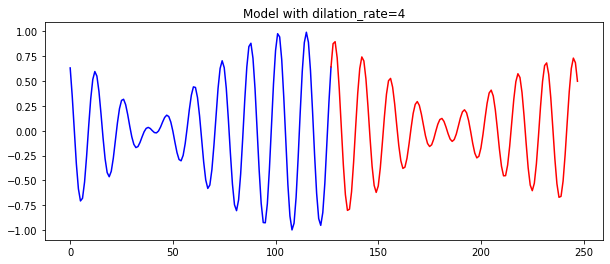

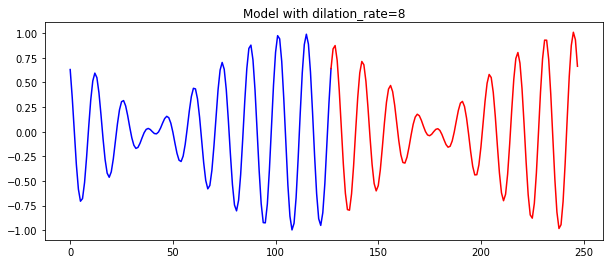

In [23]:
plot_predicted_sequence(x_test, predicted_squence2, "Model with dilation_rate=2")
plot_predicted_sequence(x_test, predicted_squence4, "Model with dilation_rate=4")
plot_predicted_sequence(x_test, predicted_squence8, "Model with dilation_rate=8")

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [24]:
model_rnn12 = Sequential([
                         SimpleRNN(units=12, input_shape = (None, 1), return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_rnn12.compile(optimizer="sgd", loss="mse")
model_rnn12.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 12)          168       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1)           0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_rnn12.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 2s 59ms/step - loss: 0.2537 - val_loss: 0.0727
Epoch 2/15
32/32 [==============================] - 2s 56ms/step - loss: 0.0604 - val_loss: 0.0590
Epoch 3/15
32/32 [==============================] - 2s 62ms/step - loss: 0.0519 - val_loss: 0.0524
Epoch 4/15
32/32 [==============================] - 2s 55ms/step - loss: 0.0469 - val_loss: 0.0484
Epoch 5/15
32/32 [==============================] - 2s 57ms/step - loss: 0.0439 - val_loss: 0.0456
Epoch 6/15
32/32 [==============================] - 2s 55ms/step - loss: 0.0403 - val_loss: 0.0434
Epoch 7/15
32/32 [==============================] - 2s 56ms/step - loss: 0.0390 - val_loss: 0.0418
Epoch 8/15
32/32 [==============================] - 2s 54ms/step - loss: 0.0375 - val_loss: 0.0405
Epoch 9/15
32/32 [==============================] - 2s 56ms/step - loss: 0.0367 - val_loss: 0.0395
Epoch 10/15
32/32 [==============================] - 2s 55ms/step - loss: 0.0361 - val_loss: 0.0386
Epoch 11/

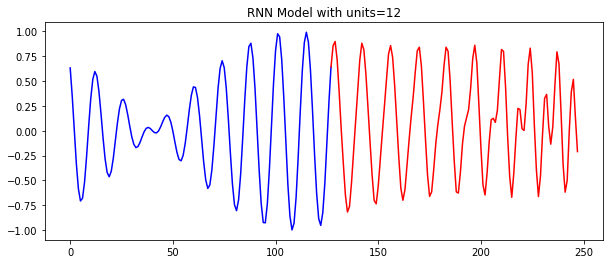

In [26]:
predicted_squence_rnn12 = predict_sequence(model_rnn12, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_rnn12, "RNN Model with units=12")

In [27]:
model_rnn24 = Sequential([
                         SimpleRNN(units=24, input_shape = (None, 1), return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_rnn24.compile(optimizer="sgd", loss="mse")
model_rnn24.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 24)          624       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           25        
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 1)           0         
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_rnn24.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 2s 64ms/step - loss: 0.1755 - val_loss: 0.0577
Epoch 2/15
32/32 [==============================] - 2s 60ms/step - loss: 0.0499 - val_loss: 0.0427
Epoch 3/15
32/32 [==============================] - 2s 61ms/step - loss: 0.0373 - val_loss: 0.0367
Epoch 4/15
32/32 [==============================] - 2s 57ms/step - loss: 0.0324 - val_loss: 0.0314
Epoch 5/15
32/32 [==============================] - 2s 57ms/step - loss: 0.0276 - val_loss: 0.0267
Epoch 6/15
32/32 [==============================] - 2s 59ms/step - loss: 0.0239 - val_loss: 0.0243
Epoch 7/15
32/32 [==============================] - 2s 62ms/step - loss: 0.0209 - val_loss: 0.0228
Epoch 8/15
32/32 [==============================] - 2s 59ms/step - loss: 0.0204 - val_loss: 0.0241
Epoch 9/15
32/32 [==============================] - 2s 56ms/step - loss: 0.0240 - val_loss: 0.0218
Epoch 10/15
32/32 [==============================] - 2s 57ms/step - loss: 0.0197 - val_loss: 0.0214
Epoch 11/

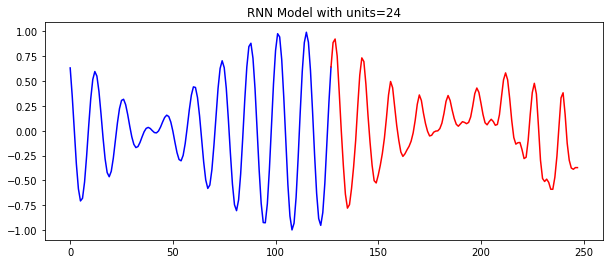

In [29]:
predicted_squence_rnn24 = predict_sequence(model_rnn24, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_rnn24, "RNN Model with units=24")

In [30]:
model_rnn_multiple = Sequential([
                         SimpleRNN(units=48, input_shape = (None, 1), return_sequences=True),
                         SimpleRNN(units=24, return_sequences=True),
                         SimpleRNN(units=12, return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_rnn_multiple.compile(optimizer="sgd", loss="mse")
model_rnn_multiple.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 48)          2400      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 24)          1752      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 12)          444       
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 1)           0         
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_rnn_multiple.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 8s 217ms/step - loss: 0.2091 - val_loss: 0.0591
Epoch 2/15
32/32 [==============================] - 6s 196ms/step - loss: 0.0540 - val_loss: 0.0482
Epoch 3/15
32/32 [==============================] - 6s 179ms/step - loss: 0.0396 - val_loss: 0.0354
Epoch 4/15
32/32 [==============================] - 6s 200ms/step - loss: 0.0342 - val_loss: 0.0354
Epoch 5/15
32/32 [==============================] - 7s 208ms/step - loss: 0.0348 - val_loss: 0.0291
Epoch 6/15
32/32 [==============================] - 6s 198ms/step - loss: 0.0280 - val_loss: 0.0273
Epoch 7/15
32/32 [==============================] - 7s 216ms/step - loss: 0.0260 - val_loss: 0.0240
Epoch 8/15
32/32 [==============================] - 7s 213ms/step - loss: 0.0236 - val_loss: 0.0224
Epoch 9/15
32/32 [==============================] - 6s 201ms/step - loss: 0.0223 - val_loss: 0.0214
Epoch 10/15
32/32 [==============================] - 7s 218ms/step - loss: 0.0214 - val_loss: 0.0212

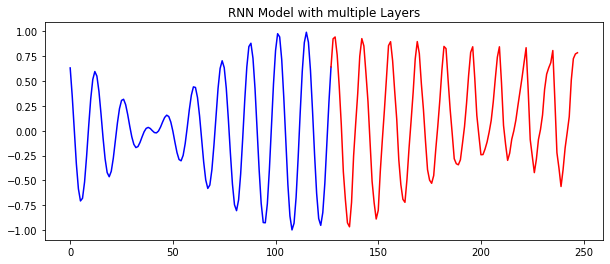

In [32]:
predicted_squence_rnn_multiple = predict_sequence(model_rnn_multiple, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_rnn_multiple, "RNN Model with multiple Layers")

### Make repeated predictions
As in A) make preaded preditions on noise less data.

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [77]:
model_lstm12 = Sequential([
                         LSTM(units=128, input_shape = (None, 1), return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_lstm12.compile(optimizer="rmsprop", loss="mse")
model_lstm12.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
dense_22 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_22 (Lambda)           (None, None, 1)           0         
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_lstm12.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 2s 22ms/step - loss: 0.1099 - val_loss: 0.0324
Epoch 2/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0301
Epoch 3/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0301 - val_loss: 0.0309
Epoch 4/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0301 - val_loss: 0.0294
Epoch 5/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 6/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0295 - val_loss: 0.0273
Epoch 7/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0238
Epoch 8/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0217 - val_loss: 0.0231
Epoch 9/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 10/15
32/32 [==============================] - 0s 8ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 11/15
32/32 

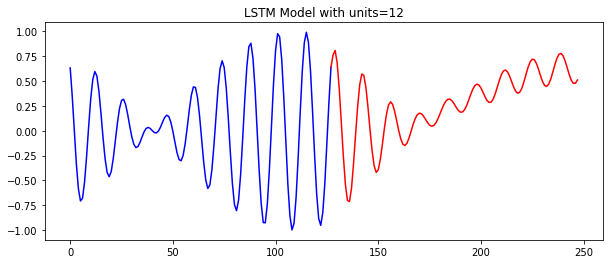

In [80]:
predicted_squence_lstm12 = predict_sequence(model_lstm12, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_lstm12, "LSTM Model with units=12")

In [61]:
model_lstm24 = Sequential([
                         LSTM(units=128*2, input_shape = (None, 1), return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_lstm24.compile(optimizer="rmsprop", loss="mse")
model_lstm24.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 256)         264192    
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           257       
_________________________________________________________________
lambda_17 (Lambda)           (None, None, 1)           0         
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_lstm24.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 2s 23ms/step - loss: 0.0937 - val_loss: 0.0336
Epoch 2/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 3/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0329
Epoch 4/15
32/32 [==============================] - 0s 10ms/step - loss: 0.0315 - val_loss: 0.0314
Epoch 5/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0278 - val_loss: 0.0278
Epoch 6/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0279 - val_loss: 0.0281
Epoch 7/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.0257
Epoch 8/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0223 - val_loss: 0.0273
Epoch 9/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0240 - val_loss: 0.0245
Epoch 10/15
32/32 [==============================] - 0s 9ms/step - loss: 0.0230 - val_loss: 0.0245
Epoch 11/15
32/32

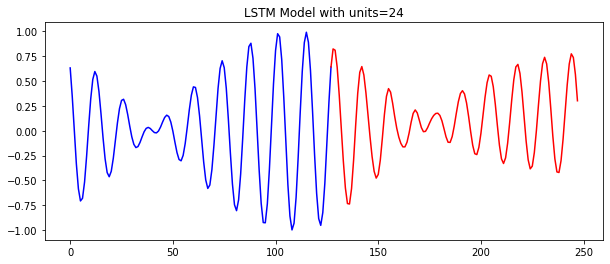

In [63]:
predicted_squence_lstm24 = predict_sequence(model_lstm24, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_lstm24, "LSTM Model with units=24")

In [111]:
model_lstm_multiple = Sequential([
                         LSTM(units=128, input_shape = (None, 1), return_sequences=True),
                         LSTM(units=64, return_sequences=True),
                         LSTM(units=32, return_sequences=True),
                         LSTM(units=16, return_sequences=True),
                         Dense(1),
                         Lambda(slice, arguments = {'slice_length': look_ahead})
                         ])

model_lstm_multiple.compile(optimizer="rmsprop", loss="mse")
model_lstm_multiple.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
lstm_75 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_76 (LSTM)               (None, None, 32)          12416     
_________________________________________________________________
lstm_77 (LSTM)               (None, None, 16)          3136      
_________________________________________________________________
dense_40 (Dense)             (None, None, 1)           17        
_________________________________________________________________
lambda_34 (Lambda)           (None, None, 1)           0         
Total params: 131,537
Trainable params: 131,537
Non-trainable params: 0
_______________________________________________

In [112]:
model_lstm_multiple.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/15
32/32 [==============================] - 7s 60ms/step - loss: 0.1753 - val_loss: 0.0566
Epoch 2/15
32/32 [==============================] - 1s 26ms/step - loss: 0.0532 - val_loss: 0.0524
Epoch 3/15
32/32 [==============================] - 1s 26ms/step - loss: 0.0444 - val_loss: 0.0345
Epoch 4/15
32/32 [==============================] - 1s 22ms/step - loss: 0.0282 - val_loss: 0.0235
Epoch 5/15
32/32 [==============================] - 1s 25ms/step - loss: 0.0221 - val_loss: 0.0241
Epoch 6/15
32/32 [==============================] - 1s 25ms/step - loss: 0.0229 - val_loss: 0.0280
Epoch 7/15
32/32 [==============================] - 1s 25ms/step - loss: 0.0206 - val_loss: 0.0208
Epoch 8/15
32/32 [==============================] - 1s 22ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 9/15
32/32 [==============================] - 1s 24ms/step - loss: 0.0178 - val_loss: 0.0212
Epoch 10/15
32/32 [==============================] - 1s 23ms/step - loss: 0.0178 - val_loss: 0.0256
Epoch 11/

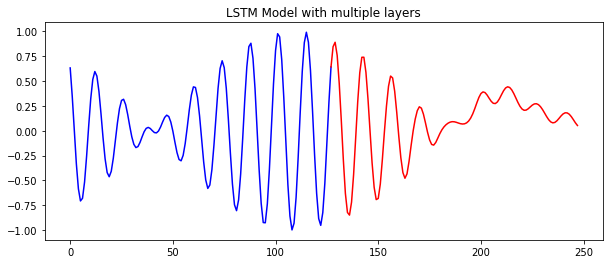

In [113]:
predicted_squence_lstm_multiple = predict_sequence(model_lstm_multiple, x_test, 12)
plot_predicted_sequence(x_test, predicted_squence_lstm_multiple, "LSTM Model with multiple layers")